In [8]:
data_dir = "dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
import os
filenames = [filename for filename in os.listdir(data_dir)]
filenames

['dev.txt', 'test.txt', 'train.txt']

In [10]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [11]:
train_lines = get_lines(data_dir+"train.txt")

Preprocess Data

In [17]:
def preprocess_text(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()


            for abstract_lines_number , abstract_line in enumerate(abstract_line_split):
                line_data ={}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_lines_number
                line_data["total_line"] = len(abstract_line_split) -1
                abstract_samples.append(line_data)
        else:
            abstract_lines+= line

    return abstract_samples

In [25]:
train_samples = preprocess_text(data_dir+"train.txt")
val_samples = preprocess_text(data_dir+"dev.txt")
test_samples = preprocess_text(data_dir+"test.txt")


In [27]:
test_samples[11]

{'target': 'METHODS',
 'text': 'resource use was determined from the amsterdam acute aneurysm ( ajax ) trial , a multicentre randomized trial comparing evar with or in patients with raaa .',
 'line_number': 2,
 'total_line': 12}

In [30]:
len(test_samples)

30135

In [31]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


In [33]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [34]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [40]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [39]:
import tensorflow as tf

In [42]:
tf.constant(test_labels_one_hot)

<tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])>

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = le.transform(val_df["target"].to_numpy())
test_labels_encoded = le.transform(test_df["target"].to_numpy())

In [45]:
num_classes = len(le.classes_)
class_names = le.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [48]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [49]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [46]:
from helper_functions import calculate_results

In [50]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [52]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

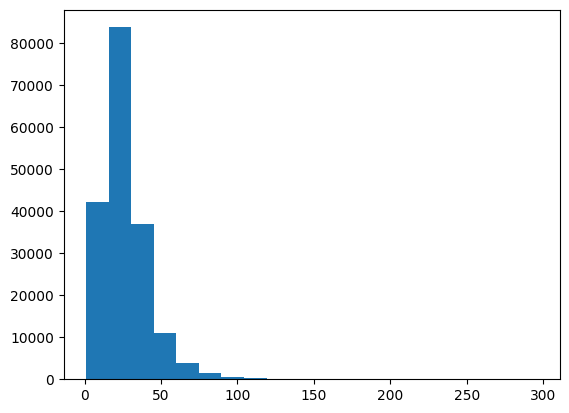

In [55]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [74]:
max_tokens = 68000
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                    output_sequence_length=55) 
text_vectorizer.adapt(train_sentences)

In [62]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the results of this follow-up study will have importance for all pregnant women and for health professionals who provide care for pregnant women .

Length of text: 24

Vectorized text:
[[   2  117    4   23   94   17   95   99 1454   11   62 1235   90    3
    11   97 1935   67  414   77   11 1235   90    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [63]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [64]:
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [84]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128,   
                               
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the results of this follow-up study will have importance for all pregnant women and for health professionals who provide care for pregnant women .

Sentence after vectorization (before embedding):
[[   2  117    4   23   94   17   95   99 1454   11   62 1235   90    3
    11   97 1935   67  414   77   11 1235   90    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.02339312  0.03600984 -0.04827587 ... -0.02131142 -0.00587035
    0.01854655]
  [ 0.04027486 -0.0163178   0.03490576 ...  0.00140178  0.00970079
   -0.01797844]
  [-0.03792406  0.0221636   0.00095807 ... -0.04982099  0.0446274
    0.04344591]
  ...
  [ 0.03120467 -0.0181995   0.00572503 ... -0.01032256  0.01534967
    0.01153045]
  [ 0.03120467 -0.0181995   0.00572503 ... -0.01032256  0.01534967
    0.01153045]
  [ 0.03120467 -0.0181995   0.00572503 .

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [67]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [83]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [85]:
model_1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:

model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 61s 106ms/step - accuracy: 0.5219 - loss: 1.1643 - val_accuracy: 0.7430 - val_loss: 0.6890
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.7499 - loss: 0.6786 - val_accuracy: 0.7743 - val_loss: 0.6248
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.7707 - loss: 0.6194 - val_accuracy: 0.7932 - val_loss: 0.5924


In [88]:
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7863 - loss: 0.5972


[0.5984662771224976, 0.7863762974739075]

In [89]:
model_1_pred_probs = model_1.predict(valid_dataset)


945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [90]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)

In [92]:
model_1_results = calculate_results(val_labels_encoded,
                                   model_1_preds)

In [93]:
model_1_results

{'accuracy': 78.63762743280816,
 'precision': 0.7825680192225314,
 'recall': 0.7863762743280815,
 'f1': 0.7834975239460843}

In [94]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [96]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [104]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the haemodynamic parameters , such as hr and map , did not differ significantly between the groups .

Sentence after embedding:
[-0.04326395 -0.01938918 -0.02060567  0.01339067  0.09039887 -0.05252882
  0.01797975  0.000887   -0.07773527  0.08419269  0.06186331 -0.04455914
 -0.04869879  0.00297296 -0.03891973  0.04330115  0.05642797  0.0147054
  0.01095849  0.04209702  0.01273969  0.07174767 -0.04543888  0.01432293
 -0.02515168 -0.03549447 -0.06176461  0.06966981 -0.04514462 -0.04036044] (truncated output)...

Length of sentence embedding:
512


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Define a custom layer to wrap the TensorFlow Hub module
class HubEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super(HubEmbeddingLayer, self).__init__(**kwargs)
        self.hub_url = hub_url

    def build(self, input_shape):
        self.embed = hub.KerasLayer(self.hub_url, trainable=False)
        # Set output spec to avoid issues with symbolic tensors
        self._output_spec = tf.TensorSpec(shape=(None, 512), dtype=tf.float32)  # Adjust shape according to your module

    def call(self, inputs):
        return self.embed(inputs)

    def compute_output_shape(self, input_shape):
        return self._output_spec.shape

# URL for the TensorFlow Hub module
hub_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"

# Define your model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = HubEmbeddingLayer(hub_url)(inputs)  # Apply the embedding layer
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [118]:
def split_chars(text):
    return " ".join(list(text))

In [120]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [121]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
     

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [123]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=290,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [125]:

char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                             
                              name="char_embed")

In [126]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [127]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [129]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4266 - loss: 1.4027 - val_accuracy: 0.5908 - val_loss: 1.0706
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5792 - loss: 1.0577 - val_accuracy: 0.6400 - val_loss: 0.9446
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6325 - loss: 0.9443 - val_accuracy: 0.6536 - val_loss: 0.8879


In [130]:
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6599 - loss: 0.8785


[0.8813985586166382, 0.6576856970787048]